Sample

## Load pre-trained EPiC-FM models

In [1]:
from DynGenModels.configs.registered_experiments import Config_JetClass_EPiC_CondFlowMatch
from DynGenModels.models.experiment import Experiment
from DynGenModels.datamodules.jetclass.dataprocess import PostProcessJetClassData as Postprocessor
from DynGenModels.datamodules.jetclass.dataprocess import PreProcessJetClassData as Preprocessor

from utils import plot_consitutents, plot_jets 

- time emebdding: Gaussian
- dim_time_emebed = 12

+----------------------+----------------------+
| Parameters           | Values               |
+----------------------+----------------------+
| NAME                 | qcd_to_top           |
| DATASET              | jetclass             |
| DATA_SOURCE          | qcd                  |
| DATA_TARGET          | top                  |
| MAX_NUM_CONSTITUENTS | 30                   |
| FEATURES             | constituents         |
| PREPROCESS           | ['standardize']      |
| DIM_INPUT            | 3                    |
| DEVICE               | cuda:0               |
| OPTIMIZER            | Adam                 |
| LR                   | 0.0001               |
| WEIGHT_DECAY         | 0.0                  |
| OPTIMIZER_BETAS      | [0.9, 0.999]         |
| OPTIMIZER_EPS        | 1e-08                |
| OPTIMIZER_AMSGRAD    | False                |
| GRADIENT_CLIP        | 1.0                  |
| SCHEDULER            |                      |
| SCHEDULER_T_MAX      |                

2024-02-23 13:35:39.675912: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-02-23 13:35:39.737309: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-02-23 13:35:39.738575: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-02-23 13:35:40.493030: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


INFO: building dataloaders...
INFO: train/val/test split ratios: 0.8/0.2/0.0
INFO: train size: 80000, validation size: 20000, testing sizes: 0
INFO: neural ODE solver with midpoint method and steps=200


  0%|          | 0/20 [00:00<?, ?it/s]

/home/df630/.conda/envs/flow_match_env/lib/python3.9/site-packages/torchdyn/numerics/odeint.py:84: UserWarning: Setting tolerances has no effect on fixed-step methods
  warn("Setting tolerances has no effect on fixed-step methods")


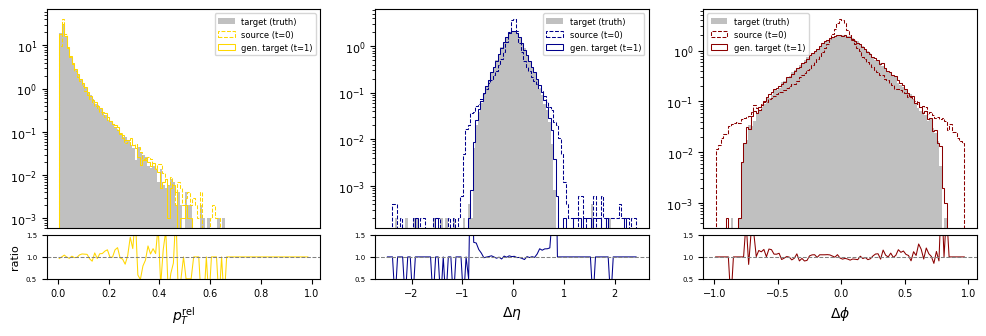

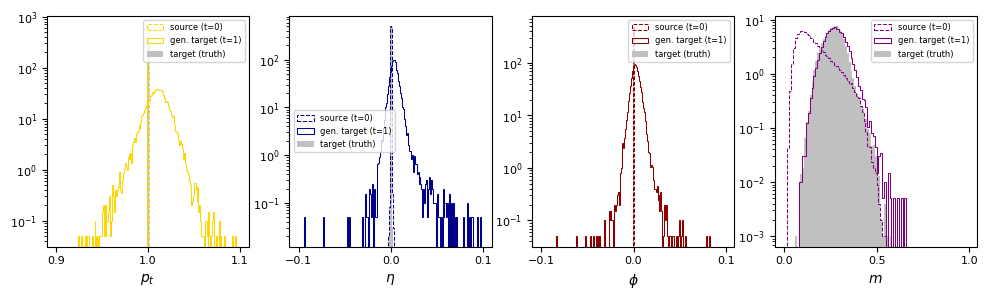

In [2]:
path = '../../results/qcd_to_top.SchrodingerBridgeCFM.EPiC.2024.02.23_09h23'
cfm = Experiment(Config_JetClass_EPiC_CondFlowMatch, path=path, DEVICE='cuda:1', )
cfm.load(model='best')
cfm.generate_samples(cfm.dataset.source_preprocess[:20000], Postprocessor=Postprocessor)
plot_consitutents(cfm, save_dir=path, features=[r'$p^{\rm rel}_T$', r'$\Delta\eta$', r'$\Delta\phi$'], figsize=(12,3.5))
plot_jets(cfm, save_dir=path, features=[r'$p_t$', r'$\eta$', r'$\phi$', r'$m$'], figsize=(12,3))

In [3]:
path = '../../results/qcd_to_top.OptimalTransportCFM.EPiC.2024.02.22_18h28'
cfm = Experiment(Config_JetClass_EPiC_CondFlowMatch, path=path, DEVICE='cuda:1', )
cfm.load(model='best')
cfm.generate_samples(cfm.dataset.source_preprocess[:20000], Postprocessor=Postprocessor)
plot_consitutents(cfm, save_dir=path, features=[r'$p^{\rm rel}_T$', r'$\Delta\eta$', r'$\Delta\phi$'], figsize=(12,3.5))
plot_jets(cfm, save_dir=path, features=[r'$p_t$', r'$\eta$', r'$\phi$', r'$m$'], figsize=(12,3))

+----------------------+---------------------+
| Parameters           | Values              |
+----------------------+---------------------+
| NAME                 | qcd_to_top          |
| DATASET              | jetclass            |
| DATA_SOURCE          | qcd                 |
| DATA_TARGET          | top                 |
| MAX_NUM_CONSTITUENTS | 30                  |
| FEATURES             | constituents        |
| PREPROCESS           | ['standardize']     |
| DIM_INPUT            | 3                   |
| DEVICE               | cuda:3              |
| OPTIMIZER            | Adam                |
| LR                   | 0.0001              |
| WEIGHT_DECAY         | 0.0                 |
| OPTIMIZER_BETAS      | [0.9, 0.999]        |
| OPTIMIZER_EPS        | 1e-08               |
| OPTIMIZER_AMSGRAD    | False               |
| GRADIENT_CLIP        | 1.0                 |
| SCHEDULER            |                     |
| SCHEDULER_T_MAX      |                     |
| SCHEDULER_E

  0%|          | 0/20 [00:00<?, ?it/s]

/home/df630/.conda/envs/flow_match_env/lib/python3.9/site-packages/torchdyn/numerics/odeint.py:84: UserWarning: Setting tolerances has no effect on fixed-step methods
  warn("Setting tolerances has no effect on fixed-step methods")


In [ ]:
path = '../../results/qcd_to_top.CFM.EPiC.2024.02.22_18h17'
cfm = Experiment(Config_JetClass_EPiC_CondFlowMatch, path=path, DEVICE='cuda:1', )
cfm.load(model='best')
cfm.generate_samples(cfm.dataset.source_preprocess[:20000], Postprocessor=Postprocessor)
plot_consitutents(cfm, save_dir=path, features=[r'$p^{\rm rel}_T$', r'$\Delta\eta$', r'$\Delta\phi$'], figsize=(12,3.5))
plot_jets(cfm, save_dir=path, features=[r'$p_t$', r'$\eta$', r'$\phi$', r'$m$'], figsize=(12,3))

+---------------------+-------------------------+
| Parameters          | Values                  |
+---------------------+-------------------------+
| NAME                | qcd_to_top_sinus        |
| DATASET             | jetclass                |
| DATA_SOURCE         | qcd                     |
| DATA_TARGET         | top                     |
| NUM_CONSTITUENTS    | 30                      |
| FEATURES            | constituents            |
| PREPROCESS          | ['standardize']         |
| DIM_INPUT           | 3                       |
| DEVICE              | cuda:1                  |
| OPTIMIZER           | Adam                    |
| LR                  | 0.0001                  |
| WEIGHT_DECAY        | 0.0                     |
| OPTIMIZER_BETAS     | [0.9, 0.999]            |
| OPTIMIZER_EPS       | 1e-08                   |
| OPTIMIZER_AMSGRAD   | False                   |
| GRADIENT_CLIP       | 1.0                     |
| SCHEDULER           |                         |


2024-02-19 18:29:14.041639: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-02-19 18:29:15.984931: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-02-19 18:29:15.992395: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-02-19 18:29:20.331395: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


INFO: building dataloaders...
INFO: train/val/test split ratios: 0.8/0.2/0.0
INFO: train size: 80000, validation size: 20000, testing sizes: 0
INFO: neural ODE solver with midpoint method and steps=200


  0%|          | 0/20 [00:00<?, ?it/s]

/home/df630/.conda/envs/flow_match_env/lib/python3.9/site-packages/torchdyn/numerics/odeint.py:84: UserWarning: Setting tolerances has no effect on fixed-step methods
  warn("Setting tolerances has no effect on fixed-step methods")


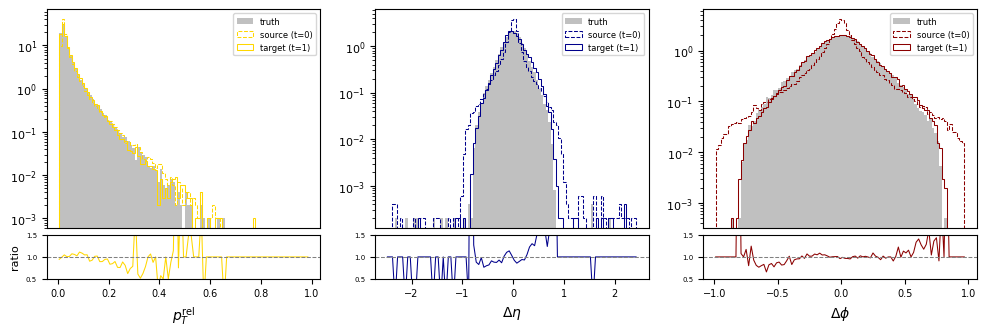

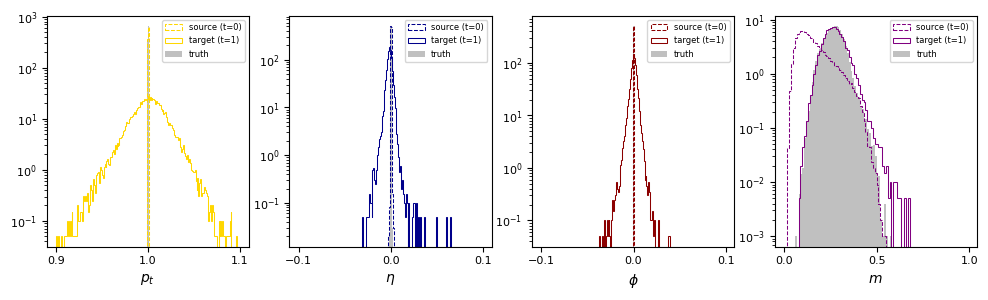

In [2]:
# path = '../../results/qcd_to_top_sinus.ConditionalFlowMatching.EPiC.2024.02.18_16h55'
# cfm = Experiment(Config_JetClass_EPiC_CondFlowMatch, path=path, DEVICE='cuda:2')
# cfm.load(model='best')

# cfm.generate_samples(cfm.dataset.source_preprocess[:20000], Postprocessor=Postprocessor)

plot_consitutents(cfm, save_dir=path, features=[r'$p^{\rm rel}_T$', r'$\Delta\eta$', r'$\Delta\phi$'], figsize=(12,3.5))
plot_jets(cfm, save_dir=path, features=[r'$p_t$', r'$\eta$', r'$\phi$', r'$m$'], figsize=(12,3))